GP Regression with GPflow
--

*James Hensman, 2015, 2016*

GP regression (with Gaussian noise) is the most straightforward GP model in GPflow. Because of the conjugacy of the latent process and the noise, the marginal likelihood $p(\mathbf y\,|\,\theta)$ can be computed exactly.

This notebook shows how to build a GPR model, estimate the parameters $\theta$ by both maximum likelihood and MCMC. 

In [1]:
import GPflow
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

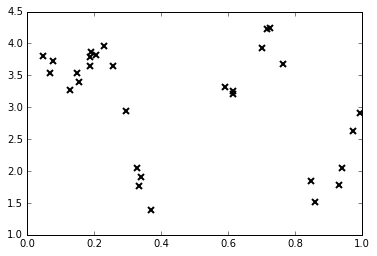

In [17]:
# build a very simple data set:
N = 30
X = np.random.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3
plt.figure()
plt.plot(X, Y, 'kx', mew=2)

Maximum Likelihood estimation
--

In [18]:
#build the GPR object
k = GPflow.kernels.Matern52(1)
meanf = GPflow.mean_functions.Linear(1,0)
m = GPflow.gpr.GPR(X, Y, k, meanf)
m.likelihood.variance = 0.01

In [19]:
print "Here are the parameters before optimization"
m

Here are the parameters before optimization


Name,values,prior,constriant
model.mean_function.A,[[ 1.]],None,(none)
model.mean_function.b,[ 0.],None,(none)
model.kern.lengthscales,[ 1.],None,+ve
model.kern.variance,[ 1.],None,+ve
model.likelihood.variance,[ 0.01],None,+ve


In [20]:
m.optimize()
print "Here are the parameters after optimization"
m

compiling tensorflow function...
done
optimization terminated, setting model state
Here are the parameters after optimization


Name,values,prior,constriant
model.mean_function.A,[[-0.80156193]],None,(none)
model.mean_function.b,[ 3.44387326],None,(none)
model.kern.lengthscales,[ 0.10442812],None,+ve
model.kern.variance,[ 0.95003395],None,+ve
model.likelihood.variance,[ 0.01005418],None,+ve


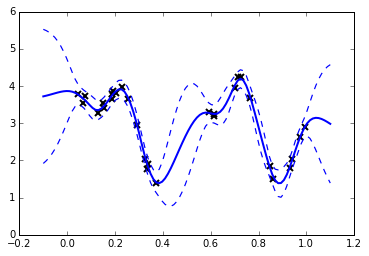

In [21]:
#plot!
xx = np.linspace(-0.1, 1.1, 100)[:,None]
mean, var = m.predict_y(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'b', lw=2)
plt.plot(xx, mean + 2*np.sqrt(var), 'b--', xx, mean - 2*np.sqrt(var), 'b--', lw=1.2)


MCMC
--
First, we'll set come priors on the kernel parameters, then we'll run mcmc and see how much posterior uncertainty there is in the parameters.

In [22]:
#we'll choose rather arbitrary priors. 
m.kern.lengthscales.prior = GPflow.priors.Gamma(1., 1.)
m.kern.variance.prior = GPflow.priors.Gamma(1., 1.)
m.likelihood.variance.prior = GPflow.priors.Gamma(1., 1.)
m.mean_function.A.prior = GPflow.priors.Gaussian(0., 10.)
m.mean_function.b.prior = GPflow.priors.Gaussian(0., 10.)
m

Name,values,prior,constriant
model.mean_function.A,[[-0.80156193]],"N([ 0.],[ 10.])",(none)
model.mean_function.b,[ 3.44387326],"N([ 0.],[ 10.])",(none)
model.kern.lengthscales,[ 0.10442812],"Ga([ 1.],[ 1.])",+ve
model.kern.variance,[ 0.95003395],"Ga([ 1.],[ 1.])",+ve
model.likelihood.variance,[ 0.01005418],"Ga([ 1.],[ 1.])",+ve


In [23]:

samples = m.sample(100, epsilon = 0.1)

AttributeError: 'module' object has no attribute 'log_gamma'

In [ ]:
plt.figure()
plt.plot(samples)

In [ ]:
#Note. All these labels are wrong (or, most probably wrong). We need some machinery for labelling posterior samples!

f, axs = plt.subplots(1,3, figsize=(12,4), tight_layout=True)
axs[0].plot(samples[:,0], samples[:,1], 'k.', alpha = 0.15)
axs[0].set_xlabel('noise_variance')
axs[0].set_ylabel('signal_variance')
axs[1].plot(samples[:,0], samples[:,2], 'k.', alpha = 0.15)
axs[1].set_xlabel('noise_variance')
axs[1].set_ylabel('lengthscale')
axs[2].plot(samples[:,2], samples[:,1], 'k.', alpha = 0.1)
axs[2].set_xlabel('lengthscale')
axs[2].set_ylabel('signal_variance')

In [ ]:
#an attempt to plot the function posterior
#Note that we should really sample the function values here, instead of just using the mean. 
#We are under-representing the uncertainty here. 
# TODO: get full_covariance of the predictions (predict_f only?)

plt.figure()

for s in samples:
    m.set_state(s)
    mean, _ = m.predict_y(xx)
    plt.plot(xx, mean, 'b', lw=2, alpha = 0.05)
    
plt.plot(X, Y, 'kx', mew=2)